# Homework #1 - Drive duration prediction



In [1]:
!python -V

Python 3.11.2


In [2]:
import os
import pickle
import psutil

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import (
    LinearRegression,
    Lasso,
    Ridge,
)
from sklearn.metrics import root_mean_squared_error

In [3]:

# Get system process information for printing memory usage:
process = psutil.Process(os.getpid())

In [4]:
def print_mem_usage_mbytes():
    print(process.memory_info().rss / (1024 * 1024)) # (in MB)
    
print_mem_usage_mbytes()

259.06640625


In [5]:
COL_DURATION = "duration"
COL_PICKUP_DT = "tpep_pickup_datetime"
COL_DROPOFF_DT = "tpep_dropoff_datetime"
COL_PICKUP_LOC = 'PULocationID'
COL_DROPOFF_LOC = 'DOLocationID'

In [6]:
def load_and_prepare_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df[COL_DROPOFF_DT] = pd.to_datetime(df[COL_DROPOFF_DT])
        df[COL_PICKUP_DT] = pd.to_datetime(df[COL_PICKUP_DT])
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df[COL_DURATION] = df[COL_DROPOFF_DT] - df[COL_PICKUP_DT]
    # convert duration to minutes
    df[COL_DURATION] = df[COL_DURATION].dt.seconds / 60
    
    categorical = [COL_DROPOFF_LOC, COL_PICKUP_LOC]
    
    df[categorical] = df[categorical].astype(str)
    
    columns = categorical + [COL_DURATION]
    
    _df = df[columns]
    
    # drop outliers
    _df = _df[(_df[COL_DURATION] >= 1) & (_df[COL_DURATION] <= 60)]
    
    return _df

In [7]:
df = pd.read_parquet('../../data/yellow_tripdata_2023-01.parquet')
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3066766 entries, 0 to 3066765
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  airport_fee           

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00


Used columns

In [8]:
df[COL_DURATION] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
df[COL_DURATION] = df[COL_DURATION].dt.seconds / 60

print(f"base metrics for duration (min):")
print(f"* mean:{df[COL_DURATION].mean()}")
print(f"* std:{df[COL_DURATION].std() }")

df[COL_DURATION].describe()

base metrics for duration (min):
* mean:15.653030467056613
* std:41.62919110966266


count    3.066766e+06
mean     1.565303e+01
std      4.162919e+01
min      0.000000e+00
25%      7.116667e+00
50%      1.151667e+01
75%      1.830000e+01
max      1.439800e+03
Name: duration, dtype: float64

In [9]:
df_ = df[(df[COL_DURATION] >= 1) & (df[COL_DURATION] <= 60)]

print(f"raw data rows: {len(df)}")
print(f"cleaned data rows: {len(df_)}")
print(f"rate cleaned rows: {100 * len(df_) / len(df)}%")

raw data rows: 3066766
cleaned data rows: 3009176
rate cleaned rows: 98.12212604417813%


In [10]:
categorical = [COL_DROPOFF_LOC, COL_PICKUP_LOC]
df_[categorical] = df_[categorical].astype(str)

df_.head()

/tmp/ipykernel_1207656/2044584250.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_[categorical] = df_[categorical].astype(str)


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,duration
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00,8.433333
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00,6.316667
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00,12.750000
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25,9.616667
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00,10.833333


In [11]:
df_val = load_and_prepare_dataframe('../../data/yellow_tripdata_2023-02.parquet')
len(df_val)

2855951

In [12]:
print_mem_usage_mbytes()

2361.9296875


In [13]:
train_dicts = df_[categorical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

print(X_train.shape)

(3009176, 515)


In [14]:
target = COL_DURATION
y_train = df_[target].values

print(len(y_train))

3009176


In [15]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

root_mean_squared_error(y_train, y_pred)

7.649261241302782

In [16]:
print_mem_usage_mbytes()

3014.78125


Somewhere after this point 
> The Kernel crashed while executing code in the current cell or a previous cell. 

In [17]:
del df
del df_

In [18]:
print_mem_usage_mbytes()

3014.78125


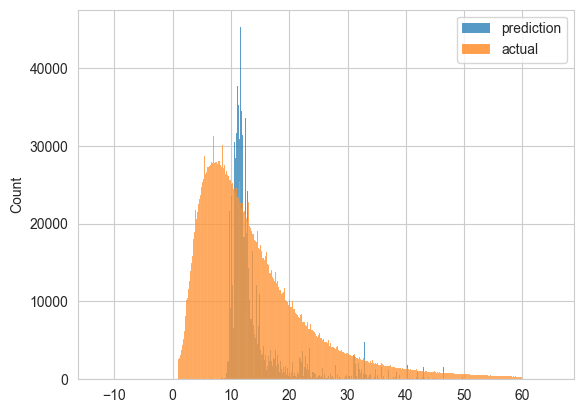

In [19]:
sns.histplot(y_pred, label='prediction')
sns.histplot(y_train, label='actual')

plt.legend()

In [20]:
plt.clf()
plt.close()

In [21]:
val_dicts = df_val[categorical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [22]:
y_val = df_val[target].values

In [23]:
y_pred = lr.predict(X_val)

root_mean_squared_error(y_val, y_pred)

7.811818537302725

In [24]:
print_mem_usage_mbytes()

3783.37890625
